# # Análisis de redes con python

**Universidad Nacional de Colombia**  
**Elaborado por:** Juan Jose Ardila Ortega


## 
Las redes o los grafos son otro metodo para modelaar y analizar las relaciones entre entidades. Y para comprenderlo mejor, estos constan de nodos o vertices y aristas o enlaces, 
que permiten relacionar claves con valores.

### ¿Por qué modelar con grafos?

Esto permite llegar a repsonder preguntas como:

*¿Quiénes son las personas influyentes clave dentro de una comunidad en línea?*
*¿Cuál es la ruta óptima entre dos ciudades en una red de transporte?*
*¿Existen clusters o comunidades densamente conectadas en la red?*

Sin embargo, en SIG el problema compun es buscar la ruta más corta  en redes, por lo que es muy frecuente encontara estos modleo en sistemas de navegación y de transporte donde el analisis es de multiples puntos. Asimismo, es posible detcetar estructuras, calcular metricas, identificar puentes criticos o detectar agrupaiones.

Para comprender de mejor manera como se comporta un grafo, la libreria **Network** permite visualizar nodos y aristas y su relación.

[1, 2, 3]
[(1, 2)]


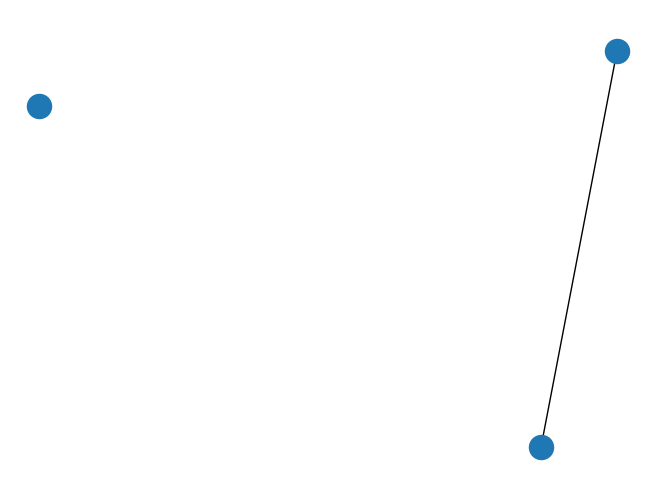

In [1]:
import networkx as nx

# Grafo vacio
G = nx.Graph()

# Añadir nodos y aristas
G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

# Inspeccionar nodos y aristas
print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

# Adjuntar metadatos
G.nodes[1]["label"] = "blue"

# Visualización básica
nx.draw(G)


Para este ejercicio se trabajara con la libreria NetworkX, la cual permite analizar redes mediante distintos algortimos de encaminamiento, como el de Dijkstra o el A*, que buscan los cmainos más cortos en las redes de transporte. Adicionalmente, el paquete OSMnx, permite trabajar con las redes de OpenStreetMap y así mismo, tiene distintas funcionalidades sobre los mismos, lo que permitira hallar la ruta más corta entre dos puntos sobre una red de trasnporte urbana.


## Obtención de la red

Gracias a OSM, es poisble extraer información de cualquier parte del mundo que cuente con información, por lo que para este caso se trabjará con datos de la Localidad de Suba en Bogotá.

In [2]:
import osmnx

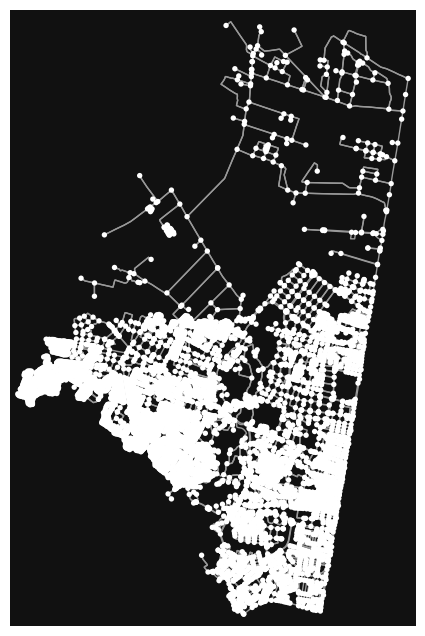

In [6]:
PLACE_NAME = "Suba, Bogotá, Colombia"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="drive"
)
figure, ax = osmnx.plot_graph(graph)


In [ ]:
Para poder hacer uso del OMSnx, es necesario preparar los datos visualizados:

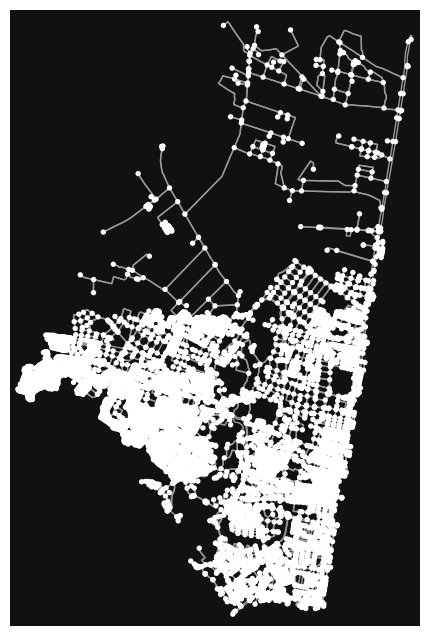

In [7]:
# Obtener el polígono del área de interés
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Reproyectar el polígono a un CRS local proyectado (Magna Sirgas Bogotá)
place_polygon = place_polygon.to_crs("EPSG:3116")

# Buffer por 200 metros
place_polygon["geometry"] = place_polygon.buffer(200)

# Reproyectar el polígono de nuevo a WGS84
place_polygon = place_polygon.to_crs("EPSG:4326")

# Recupera el gráfico de la red
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="drive"
)

fig, ax = osmnx.plot_graph(graph)

### Visión de los datos

Para este caso, sesta red que represneta las rutas de transito para vehiculos, se puede analizar que valores se le asigna a los nodos y las aristas, 
por lo que se transforma la red en un marco de datos geográfico, que se visualiza como tabla y muestra las relaciones atribuibles entre los nodos y las aristas encontradas.


In [8]:
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid     highway lanes maxspeed  \
u         v          key                                                       
259665451 5718775594 0                  809284675       trunk     3       50   
          273536445  0                 1153629523       trunk     2       60   
259705339 259705340  0    [1326283107, 913056613]       trunk     3      NaN   
259705340 273536194  0                   25123212  trunk_link     1      NaN   
          4096482172 0                  913056617       trunk     2      NaN   

                                        name  oneway reversed      length  \
u         v          key                                                    
259665451 5718775594 0    Avenida Carrera 45    True    False  745.334231   
          273536445  0    Avenida Carrera 45    True    False  110.133567   
259705339 259705340  0    Avenida Carrera 45    True    False  122.389094   
259705340 273536194  0                   NaN    True    False  253.568306   
          4096482172 0    Avenida Carrera 45    True    False   68.598364   

                                                                   geometry  \
u         v          key                                                      
259665451 5718775594 0    LINESTRING (-74.04663 4.75285, -74.04657 4.752...   
          273536445  0    LINESTRING (-74.04663 4.75285, -74.04663 4.752...   
259705339 259705340  0    LINESTRING (-74.04657 4.75075, -74.04654 4.750...   
259705340 273536194  0    LINESTRING (-74.04636 4.75183, -74.04628 4.752...   
          4096482172 0    LINESTRING (-74.04636 4.75183, -74.04629 4.752...   

                          ref bridge access junction width  
u         v          key                                    
259665451 5718775594 0    NaN    NaN    NaN      NaN   NaN  
          273536445  0    NaN    NaN    NaN      NaN   NaN  
259705339 259705340  0    NaN    NaN    NaN      NaN   NaN  
259705340 273536194  0    NaN    NaN    NaN      NaN   NaN  
          4096482172 0    NaN    NaN    NaN      NaN   NaN

Es posible mirar de que tipo de calles se compone la red.

In [9]:
edges["highway"].value_counts()

highway
residential                    14087
tertiary                        2219
secondary                        894
primary                          607
trunk                            364
trunk_link                       114
primary_link                      79
unclassified                      54
tertiary_link                     13
secondary_link                    12
[residential, unclassified]        4
[primary_link, primary]            2
[tertiary, residential]            1
[residential, tertiary]            1
[trunk, primary]                   1
Name: count, dtype: int64

### Transformación a sistema de referencia proyectado

El sistema de referencia base es el WGS84, sin embargo, es geográfico. Sin embargo, los valores obtenidos son en valores en grados, 
pero los valores para analizar debería ser en metros.

Por lo que se torna de gran importancia transformar los goedatos de entrada, si este valor del sistema de proyección no se pone,
automaticamente se pondra un UTM más apropiado.

In [10]:
# Transformar el gráfico a UTM
graph = osmnx.project_graph(graph) 

# Extraer nodos y aristas reproyectados
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Análisis de las propiedades de la red

Luego de preparar el grafo, es posible calcular las estadísticas y características básicas del mismo:


In [11]:
# Calcular las estadísticas de la red
osmnx.basic_stats(graph)

{'n': 7681,
 'm': 18452,
 'k_avg': 4.8045827366228355,
 'edge_length_total': 1575632.9676006532,
 'edge_length_avg': 85.3909043789645,
 'streets_per_node_avg': 2.8220283817211302,
 'streets_per_node_counts': {0: 0, 1: 1346, 2: 21, 3: 4981, 4: 1320, 5: 13},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.17523759927092827,
  2: 0.002734019007941674,
  3: 0.648483270407499,
  4: 0.1718526233563338,
  5: 0.0016924879572972268},
 'intersection_count': 6335,
 'street_length_total': 949307.7042815512,
 'street_segment_count': 10760,
 'street_length_avg': 88.2256230744936,
 'circuity_avg': 1.0427189872501874,
 'self_loop_proportion': 0.0009293680297397769}

Para obtener estadísticas mas robustas, es posible generar un polígono envolvente y así analizar el área que afecta esta red.


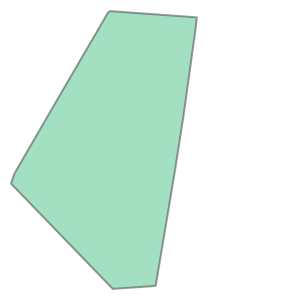

In [12]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [13]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 7681,
 'm': 18452,
 'k_avg': 4.8045827366228355,
 'edge_length_total': 1575632.9676006532,
 'edge_length_avg': 85.3909043789645,
 'streets_per_node_avg': 2.8220283817211302,
 'streets_per_node_counts': {0: 0, 1: 1346, 2: 21, 3: 4981, 4: 1320, 5: 13},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.17523759927092827,
  2: 0.002734019007941674,
  3: 0.648483270407499,
  4: 0.1718526233563338,
  5: 0.0016924879572972268},
 'intersection_count': 6335,
 'street_length_total': 949307.7042815512,
 'street_segment_count': 10760,
 'street_length_avg': 88.2256230744936,
 'circuity_avg': 1.0427189872501874,
 'self_loop_proportion': 0.0009293680297397769,
 'node_density_km': 69.62557102857201,
 'intersection_density_km': 57.42455311365755,
 'edge_density_km': 14282.560226616191,
 'street_density_km': 8605.141386854026}

In [24]:
Primero se debe realizar una copia de la información, para poder explotar los valores que incluye la lista de la columna **Highway**.

In [14]:
edges_1= edges.copy()

edges_1=edges_1.explode("highway")

edges_1["highway"]= edges_1["highway"].fillna("unknow").astype(str)

In [ ]:
1. **Calcular** el total de las longitudes de las calles resideniales, priamrias y secundarias.

In [15]:
Long_Clase_Km= (
    edges_1.groupby("highway")["length"]
    .sum()
    .sort_values(ascending=False)
    / 1000
)

Long_Clase_Km.loc[["residential", "primary", "secondary"]]


highway
residential    1115.665317
primary          78.169756
secondary        69.396288
Name: length, dtype: float64

In [ ]:
2. **Comparar** la media de las clases.

In [16]:
Media_Clase= (
    edges_1.groupby("highway")["length"]
    .mean()
    .sort_values(ascending=False)
)

display(Media_Clase)


highway
unclassified      582.776610
trunk             188.630625
trunk_link        143.169689
primary           128.147142
tertiary           85.720085
primary_link       82.811493
residential        79.164501
secondary          77.624484
secondary_link     57.679791
tertiary_link      17.501407
Name: length, dtype: float64

In [ ]:
3. **Visualizar** las 5 clases con mayor longitud de calles.

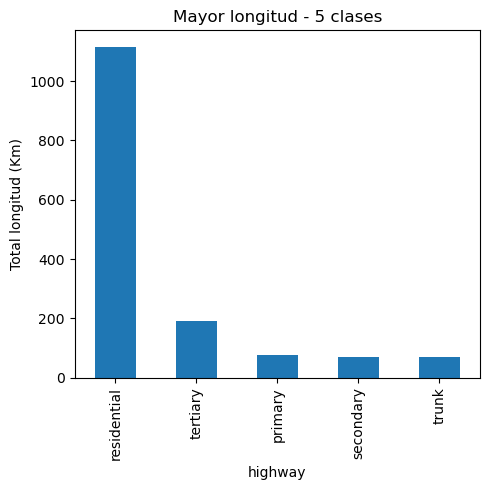

In [17]:
import matplotlib.pyplot as plt

Long_Clase_Km.head(5).plot(kind="bar", figsize=(5, 5))
plt.ylabel("Total longitud (Km)")
plt.title("Mayor longitud - 5 clases")
plt.tight_layout()
plt.show()

## Análisis del camino más corto

Para poder realizar este calculo entre dos puntos conocidos se debe preparar lo siguiente:


In [18]:
#Punto de origen
origin = (
    osmnx.geocode_to_gdf("parque la gaitana, bogota")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

#Punto de destino
destination = (
    osmnx.geocode_to_gdf("cerro la conejera, bogota")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

Posteriormente, es posible buscar un nodo ocncido en el grafo, que se aproxime a los valores añadidos con anterioridad.

In [19]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

507912169

In [20]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

310327256

### Enrutamiento

Ya creado los puntos de origen y destino, es posible, hacer uso del grafo y de los identificadores de los nodos de origen y destino.


In [21]:
# Encontrar el camino más corto entre el origen y el destino
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[507912169,
 507912081,
 5113954454,
 507705392,
 5113954459,
 507943335,
 507943334,
 1068231784,
 1068231480,
 1068231555,
 1068559811,
 507943310,
 310613550,
 320196272,
 4064302678,
 310613554,
 507180826,
 6453782953,
 507173627,
 1068231544,
 310613556,
 504421079,
 323327696,
 323327927,
 323328020,
 320196083,
 507144041,
 323328271,
 320196045,
 514597063,
 310613561,
 514611064,
 514602806,
 4064302677,
 871073063,
 262391363,
 310613563,
 871072962,
 514539058,
 871073072,
 262391121,
 262391335,
 871073047,
 871072958,
 1833722136,
 896307122,
 4913349660,
 5378334896,
 5379505621,
 312094081,
 4226160270,
 517610906,
 5379680136,
 4863130265,
 5379680109,
 5930273582,
 4198906778,
 316735957,
 4136288075,
 4112524442,
 5379785795,
 5379785797,
 517647649,
 317503619,
 5379785956,
 308903869,
 5379785763,
 998072991,
 316736092,
 517738973,
 308903871,
 5163394843,
 8232838620,
 517753307,
 5379785941,
 317503653,
 9849222121,
 1868086124,
 1868086125,
 1868086132,
 540044

El anterior listado, muestra los nodos que conectan estos dos puntos y es posible generar geodataframe, que muestre gráficamente la línea.

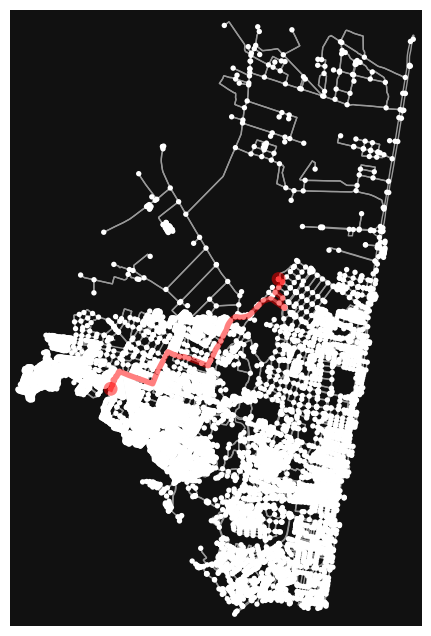

In [22]:
# Trazar el camino más corto
fig, ax = osmnx.plot_graph_route(graph, route)

### 3.4. 🚀 **Now it’s your turn! — Alternative routes**

1. **Calculate** a second route that avoids `motorway` and `trunk` streets.  
2. **Compare** its length with the original shortest route.  
3. **Discuss** in one sentence why constrained routes can be useful for certain users.

> 💡 You can filter `edges` before building a sub-graph or use `osmnx.utils_graph.get_route_edge_attributes`.


In [22]:
#write your code here

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable
information for many applications.  Here, we only analyzed the shortest paths
based on distance but quite often it is more useful to find the optimal routes
between locations based on the travelled time. Here, for example we could
calculate the time that it takes to cross each road segment by dividing the
length of the road segment with the speed limit and calculate the optimal
routes by taking into account the speed limits as well that might alter the
result especially on longer trips than here.



## 4. Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and
visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a
linestring and save the shortest path geometry and related attributes into a
geopackage file.

First we need to get the nodes that belong to the shortest path:

In [19]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
253761979,516676.410483,604611.155660,3,-74.056813,4.673795,NaN,POINT (604611.156 516676.41)
312644380,516704.464921,604550.631990,3,-74.057358,4.674049,NaN,POINT (604550.632 516704.465)
253762072,516598.676408,604500.503679,3,-74.057811,4.673093,crossing,POINT (604500.504 516598.676)
253762005,516563.310902,604484.167784,3,-74.057959,4.672773,NaN,POINT (604484.168 516563.311)
253761879,516416.830310,604485.218080,3,-74.057951,4.671448,NaN,POINT (604485.218 516416.83)
...,...,...,...,...,...,...,...
4158543992,511601.415684,604028.816224,3,-74.062123,4.627896,NaN,POINT (604028.816 511601.416)
11363324731,511465.333304,604051.126428,3,-74.061924,4.626665,NaN,POINT (604051.126 511465.333)
2815787892,511388.089544,603941.518828,3,-74.062913,4.625967,NaN,POINT (603941.519 511388.09)


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

Now we can create a LineString out of the Point geometries of the nodes:

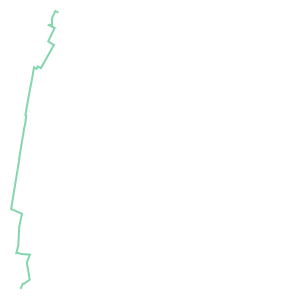

In [20]:
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

Now we have the route as a LineString geometry. 

Let's make a GeoDataFrame out of it having some useful information about our
route such as a list of the osmids that are part of the route and the length
of the route.

In [21]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (604611.156 516676.41, 604550.632 5...","[253761979, 312644380, 253762072, 253762005, 2...",6552.271653


Now we have a GeoDataFrame that we can save to disk. Let's still confirm that
everything is ok by plotting our route on top of our street network and some
buildings, and plot also the origin and target points on top of our map.

Download buildings:

In [22]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

AttributeError: module 'osmnx' has no attribute 'features_from_place'

In [23]:
import osmnx as ox

buildings = ox.geometries_from_place(
    PLACE_NAME,
    tags={"building": True}
).to_crs(edges.crs)


Let's now plot the route and the street network elements to verify that
everything is as it should:

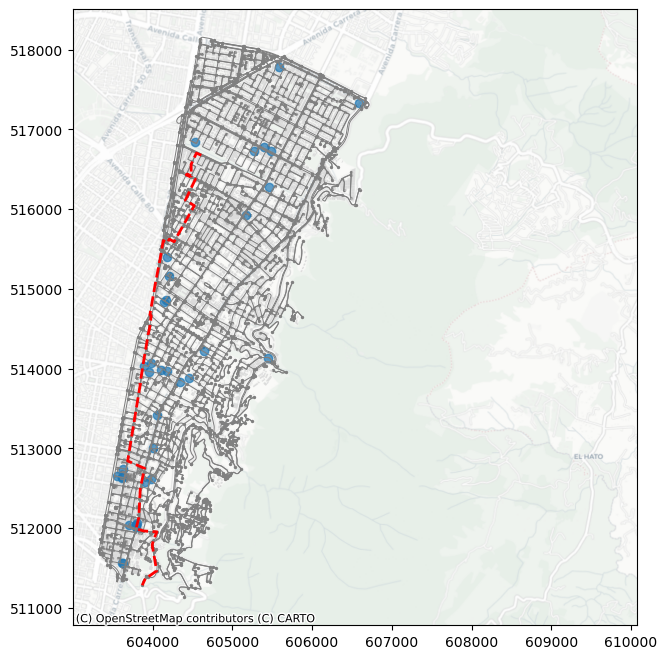

In [24]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

Great everything seems to be in order! As you can see, now we have a full
control of all the elements of our map and we can use all the aesthetic
properties that matplotlib provides to modify how our map will look like. Now
we are almost ready to save our data into disk.



## Prepare data for saving to file

The data contain certain data types (such as `list`) that should be converted
into character strings prior to saving the data to file (an alternative would be
to drop invalid columns).

In [25]:
edges.head()

osmid  oneway lanes  \
u          v          key                                       
253761879  9644335932 0               583975820    True     3   
           253762005  0    [23430423, 23430447]   False     2   
9644335932 268083093  0               583975820    True     3   
           268083092  0              1049447128    True   NaN   
253762005  253761879  0    [23430447, 23430423]   False     2   

                                              name         highway reversed  \
u          v          key                                                     
253761879  9644335932 0           Avenida Calle 85       secondary    False   
           253762005  0    [Carrera 19A, Calle 86]     residential    False   
9644335932 268083093  0           Avenida Calle 85       secondary    False   
           268083092  0                        NaN  secondary_link    False   
253762005  253761879  0    [Calle 86, Carrera 19A]     residential     True   

                            length  \
u          v          key            
253761879  9644335932 0     55.642   
           253762005  0    195.089   
9644335932 268083093  0      6.999   
           268083092  0     15.837   
253762005  253761879  0    195.089   

                                                                    geometry  \
u          v          key                                                      
253761879  9644335932 0    LINESTRING (604485.218 516416.83, 604434.993 5...   
           253762005  0    LINESTRING (604485.218 516416.83, 604487.131 5...   
9644335932 268083093  0    LINESTRING (604434.993 516440.731, 604428.678 ...   
           268083092  0    LINESTRING (604434.993 516440.731, 604430.902 ...   
253762005  253761879  0    LINESTRING (604484.168 516563.311, 604541.164 ...   

                          maxspeed width access service bridge junction tunnel  
u          v          key                                                       
253761879  9644335932 0        NaN   NaN    NaN     NaN    NaN      NaN    NaN  
           253762005  0        NaN   NaN    NaN     NaN    NaN      NaN    NaN  
9644335932 268083093  0        NaN   NaN    NaN     NaN    NaN      NaN    NaN  
           268083092  0        NaN   NaN    NaN     NaN    NaN      NaN    NaN  
253762005  253761879  0        NaN   NaN    NaN     NaN    NaN      NaN    NaN

In [26]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [27]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

Now we can see that most of the attributes are of type `object` that quite
often (such as ours here) refers to a string type of data.

## Save the data:

In [28]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data1"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

### 🚀 **Now it’s your turn! — Extending your analysis**

1. **Create** a 50 m buffer around the route and select buildings intersecting it.  
2. **Count** buildings both in total and by `building` tag within this corridor.  
3. **Export** the result to `buildings_along_route.geojson`.  

> 💡 Try `buildings[buildings.intersects(buffer)]` or a spatial overlay with GeoPandas.



In [29]:
buffer_50m = route_line.buffer(50)
buildings_near = buildings[buildings.intersects(buffer_50m)]
buildings_near["building"].value_counts()

building
yes                                  258
apartments                            85
commercial                            71
residential                           44
house                                 24
university                            18
retail                                13
office                                 4
construction                           4
roof                                   3
public                                 2
kiosk                                  1
government                             1
school                                 1
Posgrados_Universidad_Santo_Tomas      1
college                                1
Name: count, dtype: int64

In [141]:
# Write your script here


Total buildings within 50 m: 532


building
yes                                  259
apartments                            85
commercial                            71
residential                           44
house                                 24
university                            18
retail                                14
office                                 4
roof                                   3
construction                           3
public                                 2
kiosk                                  1
Posgrados_Universidad_Santo_Tomas      1
school                                 1
government                             1
college                                1
Name: count, dtype: int64

Exported to 'buildings_along_route.geojson'


Great, now we have saved all the data that was used to produce the maps into a geopackage.



## Advanced reading

Here we learned how to solve a simple routing task between origin and
destination points. What about if we have hundreads or thousands of origins?
This is the case if you want to explore the travel distances to a spesific
location across the whole city, for example, when analyzing the accessibility
of jobs and services (like in the Travel Time Matrix dataset used in previous
sections). 

Check out pyrosm documentation on [working with
graphs](https://pyrosm.readthedocs.io/en/latest/graphs.html#working-with-graphs)
for more advanced examples of network analysis in python. For example,
[pandana](https://udst.github.io/pandana/) is a fast and efficient python
library for creating aggretated network analysis in no time across large
networks, and pyrosm can be used for preparing the input data for such
analysis.